In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gc
from tqdm import tqdm

%matplotlib inline

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rcParams['axes.facecolor']='white'
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [83]:
# Prepare lists to store the flattened images and labels
images = []
labels = []

# Loop over each file in the directory
for filename in os.listdir("Images"):
    file_path = os.path.join("Images", filename)
    with Image.open(file_path) as img:
        images.append(np.array(img))
        # Extract the class label from the filename
        # Example filename: yaleB01_P00A+000E+00.png
        # Extract '01' from 'yaleB01', which is the subject ID
        label = filename.split('_')[0]
        label = label[5:7]
        labels.append(label)

# Convert lists to numpy arrays
image_matrix = np.array(images)
label_array = np.array(labels)

#Apply data normalization with mean and standard deviation
image_matrix = (image_matrix - np.mean(image_matrix, axis=0)) / np.std(image_matrix, axis=0)

print("Image matrix shape:", image_matrix.shape)
print("Labels array shape:", label_array.shape)


KeyboardInterrupt



In [48]:
#Alternatively, read from the pickle
import pickle
with open('young_matrix.pkl', 'rb') as file:
    image_matrix = pickle.load(file)

with open('young_labels.pkl', 'rb') as file:
    label_array = np.array(pickle.load(file))

original_dimensions = (144, 104)
image_matrix = image_matrix.reshape(-1, original_dimensions[0], original_dimensions[1])

In [49]:
# Unique classes in the dataset
unique_classes = np.unique(label_array)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train = image_matrix[train_indices]
X_test = image_matrix[test_indices]
y_train = label_array[train_indices].astype(int)
y_test = label_array[test_indices].astype(int)

#Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train, X_train)  # Autoencoder uses the same data for input and target
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Parameters
encoding_dim = 32  # Arbitrary n, you can change it based on your needs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

#Clear memory
torch.cuda.empty_cache()
gc.collect()

Device:  cuda


141

In [50]:
class ConvAutoencoder(nn.Module):
    def __init__(self, n, input_dim):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 2, stride=2),  # Input: (1, 192, 168), Output: (4, 96, 84)
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 16, 2, stride=2),  # Output: (16, 48, 42)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 2, stride=2),  # Output: (64, 24, 21)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * int(input_dim[0] / 8)  * int(input_dim[1] / 8), n)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, 64 * int(input_dim[0] / 8) * int(input_dim[1] / 8)),
            nn.Unflatten(dim=1, unflattened_size=(64, int(input_dim[0] / 8), int(input_dim[1] / 8))),
            nn.ConvTranspose2d(64, 16, 2, stride=2),  # Output: (16, 48, 42)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, 2, stride=2),  # Output: (4, 96, 84)
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 2, stride=2),   # Output: (1, 192, 168)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [51]:
logistic_classifier = LogisticRegression(random_state = 42, C = 0.005, max_iter = 500)
svm_classifier = SVC(kernel = 'linear', random_state = 42, C = 0.001, max_iter = 500)

In [35]:
# Assuming you have your model and optimizer already defined
model = ConvAutoencoder(32, (image_matrix.shape[1], image_matrix.shape[2])).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

train_losses = []
val_losses = []
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    for data in train_loader:
        inputs, targets = data
        inputs, targets = inputs.unsqueeze(1).to(device), targets.unsqueeze(1).to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        
        running_train_loss += loss.item()
    
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loss
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.unsqueeze(1).to(device), targets.unsqueeze(1).to(device)
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            
            running_val_loss += loss.item()
    
    val_loss = running_val_loss / len(test_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.9473, Validation Loss: 0.7094
Epoch [2/100], Train Loss: 0.7102, Validation Loss: 0.5694
Epoch [3/100], Train Loss: 0.6000, Validation Loss: 0.4952
Epoch [4/100], Train Loss: 0.5186, Validation Loss: 0.4232
Epoch [5/100], Train Loss: 0.4637, Validation Loss: 0.3798
Epoch [6/100], Train Loss: 0.4128, Validation Loss: 0.3349
Epoch [7/100], Train Loss: 0.3778, Validation Loss: 0.3239
Epoch [8/100], Train Loss: 0.3398, Validation Loss: 0.2724
Epoch [9/100], Train Loss: 0.3082, Validation Loss: 0.2523
Epoch [10/100], Train Loss: 0.2824, Validation Loss: 0.2336
Epoch [11/100], Train Loss: 0.2700, Validation Loss: 0.2281
Epoch [12/100], Train Loss: 0.2414, Validation Loss: 0.1932
Epoch [13/100], Train Loss: 0.2276, Validation Loss: 0.1871
Epoch [14/100], Train Loss: 0.2107, Validation Loss: 0.1738
Epoch [15/100], Train Loss: 0.1962, Validation Loss: 0.1564
Epoch [16/100], Train Loss: 0.1870, Validation Loss: 0.1526
Epoch [17/100], Train Loss: 0.1766, Validation Lo

In [13]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
num_params = count_trainable_parameters(model)
print(f'Number of trainable parameters for latent dimension size of 32: {num_params}')

Number of trainable parameters for latent dimension size of 32: 53978


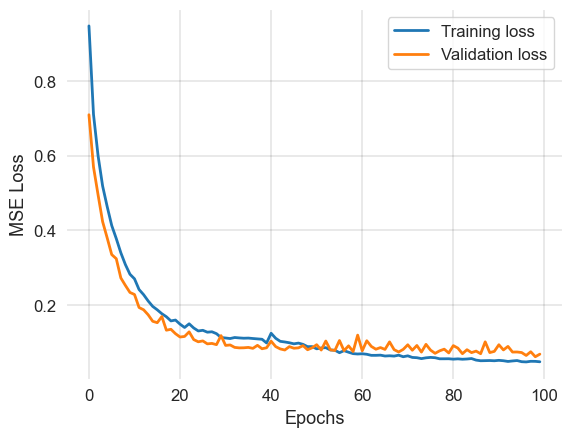

In [37]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training loss', linewidth=2)
plt.plot(val_losses, label='Validation loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(color='black', linewidth=0.25, alpha=0.5)
plt.legend()
plt.show()

In [37]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [52]:
component_list = [1, 100, 200]
logistic_accuracies = []
svm_accuracies = []
for n in component_list:
    model = ConvAutoencoder(n, (image_matrix.shape[1], image_matrix.shape[2])).to(device)
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

    # Training the autoencoder
    num_epochs = 50
    for epoch in tqdm(range(num_epochs)):
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.unsqueeze(1).to(device), targets.unsqueeze(1).to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    with torch.no_grad():
        X_train_encoded = model.encoder(X_train.unsqueeze(1).to(device)).cpu().numpy()
        X_test_encoded = model.encoder(X_test.unsqueeze(1).to(device)).cpu().numpy()

    logistic_accuracy = evaluate_model(logistic_classifier, X_train_encoded, y_train.numpy(), X_test_encoded, y_test.numpy())
    logistic_accuracies.append(logistic_accuracy)

    svm_accuracy = evaluate_model(svm_classifier, X_train_encoded, y_train.numpy(), X_test_encoded, y_test.numpy())
    svm_accuracies.append(svm_accuracy)

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]
C:\Users\korki\anaconda3\envs\mnlp\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 50/50 [01:23<00:00,  1.67s/it]
C:\Users\korki\anaconda3\envs\mnlp\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
100%|██████████| 50/50 [01:45<00:00,  2.12s/it]
C:\Users\korki\anaconda3\envs\mnlp\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [53]:
logistic_accuracies, svm_accuracies

([0.5133333333333333, 0.6773333333333333, 0.6853333333333333],
 [0.5173333333333333, 0.49866666666666665, 0.5533333333333333])

In [19]:
with torch.no_grad():
    X_train_encoded = model.encoder(X_train.unsqueeze(1).to(device)).cpu().numpy()
    X_test_encoded = model.encoder(X_test.unsqueeze(1).to(device)).cpu().numpy()

logistic_accuracy = evaluate_model(logistic_classifier, X_train_encoded, y_train.numpy(), X_test_encoded, y_test.numpy())
svm_accuracy = evaluate_model(svm_classifier, X_train_encoded, y_train.numpy(), X_test_encoded, y_test.numpy())

In [16]:
#pickle the accuracies
import pickle
with open('auto_log_accuracies.pkl', 'wb') as file:
    pickle.dump(logistic_accuracies, file)
    
with open('auto_svm_accuracies.pkl', 'wb') as file:
    pickle.dump(svm_accuracies, file)